## Credit Risk

**Task**: Make a model to assess whether or not a new customer is likely to pay back the loan

- The dataset only contains accepted loans

- Data source including credit report, payment behavior for accept, self-claim, which were collected at the application stage, listed stage or during payment 

- To predict default of application, we only use information avaliable at application stage


In [1]:
import numpy as np 
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')


# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', 1000, 'display.max_columns', 1000)

# Plotting options
%matplotlib inline
mp.style.use('ggplot')
sns.set(style='whitegrid')

import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing,metrics 

from utils import *

In [2]:
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency

## Step 1 Loan Data

- The sample contains data from 2017 to 2018 
- Dimension: 2260k * 151
- Definition of data：[lending clud](https://www.lendingclub.com/investing/peer-to-peer)


In [3]:
df = pd.read_csv('input/accepted_2007_to_2018Q4.csv', parse_dates=['issue_d'])
df = df[(df.issue_d >= '2018-01-01 00:00:00') & (df.issue_d < '2019-01-01 00:00:00')]
df.shape

(495242, 151)

In [4]:
df.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
753206,140373092,NaN,25000.0,25000.0,25000.0,60 months,14.47,587.82,C,C2,Manager,2 years,MORTGAGE,60000.0,Source Verified,2018-09-01,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=140373092,NaN,home_improvement,Home improvement,208xx,MD,9.63,0.0,Jul-2007,700.0,704.0,0.0,72.0,NaN,6.0,0.0,6037.0,24.9,8.0,w,20247.54,20247.54,6306.820000,6306.82,4752.46,1554.36,0.0,0.0,0.0,Mar-2019,587.82,Apr-2019,Mar-2019,719.0,715.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,301194.0,0.0,1.0,1.0,1.0,7.0,6783.0,85.0,0.0,0.0,4114.0,40.0,24200.0,2.0,0.0,3.0,2.0,50199.0,18163.0,24.9,0.0,0.0,7.0,134.0,30.0,7.0,1.0,30.0,72.0,7.0,72.0,0.0,4.0,4.0,4.0,5.0,1.0,4.0,6.0,4.0,6.0,0.0,0.0,0.0,2.0,87.5,0.0,0.0,0.0,323327.0,12820.0,24200.0,8000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1384552,143516342,NaN,6000.0,6000.0,6000.0,36 months,7.02,185.32,A,A2,Pest Control Technician,7 years,OWN,62000.0,Not Verified,2018-12-01,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=143516342,NaN,debt_consolidation,Debt consolidation,701xx,LA,28.89,0.0,Sep-2004,745.0,749.0,0.0,61.0,NaN,19.0,0.0,6243.0,9.8,33.0,w,5546.70,5546.70,551.280000,551.28,453.30,97.98,0.0,0.0,0.0,Mar-2019,185.32,Apr-2019,Mar-2019,749.0,745.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,85624.0,1.0,9.0,3.0,7.0,5.0,73059.0,100.0,0.0,1.0,3174.0,45.0,63500.0,6.0,4.0,2.0,8.0,4757.0,33885.0,13.8,0.0,0.0,170.0,133.0,22.0,5.0,0.0,56.0,NaN,11.0,NaN,0.0,4.0,5.0,5.0,9.0,18.0,9.0,14.0,5.0,19.0,0.0,0.0,0

#### 1.1 Remove columns with all missing or all same value

In [5]:
missing_fractions = df.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable
missing_fractions.head(10)

member_id                                     1.000000
desc                                          1.000000
orig_projected_additional_accrued_interest    0.999352
hardship_start_date                           0.999257
hardship_end_date                             0.999257
payment_plan_start_date                       0.999257
hardship_length                               0.999257
hardship_dpd                                  0.999257
hardship_loan_status                          0.999257
hardship_last_payment_amount                  0.999257
dtype: float64

Text(0, 0.5, 'Feature count')

findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.


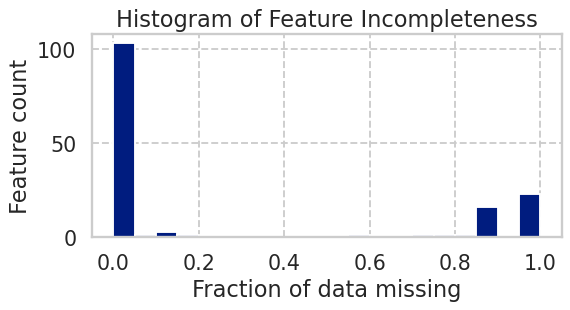

In [6]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

- About 60% of feature have missing rate < 20%
- Remove columns with 100% missing
- Remove columns with identical values

In [7]:
drop_na = sorted(list(missing_fractions[missing_fractions == 1].index))
print(len(drop_na))
df.drop(labels=drop_na, axis=1, inplace=True, errors='ignore')
print(df.shape)

2
(495242, 149)


In [8]:
identical_fractions = df.apply(pd.Series.nunique)
drop_iden = sorted(list(identical_fractions[identical_fractions == 1].index))
print(len(drop_iden ))
df.drop(labels=drop_iden, axis=1, inplace=True, errors='ignore')
print(df.shape)

5
(495242, 144)


#### 1.2 convert all object column to lower case

In [9]:
df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

## Step 2 EDA 

### 2.1 Response Variables

- loan_status: predict whether or not the loan will pay back
- Grades: predict the risk band, not the main task of this scripts


**loan_status**
- bad: Default, Charged Off 
- good: Fully Paid
- indeterminate: Late (31-120 days), Late (16-30 days), Current, In Grace Period 

We only keep loan_status which is Fully Paid or Charged Off

In [10]:
df['loan_status'].value_counts(dropna=False)

current               427181
fully paid             47444
charged off             8867
late (31-120 days)      7221
in grace period         2919
late (16-30 days)       1603
default                    7
Name: loan_status, dtype: int64

In [11]:
df = df.loc[df['loan_status'].isin(['fully paid', 'charged off'])]

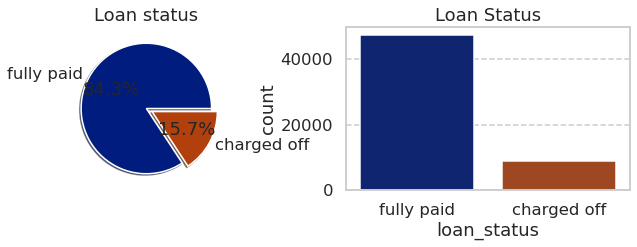

In [12]:
f,ax=plt.subplots(1,2,figsize=(10,3))
df['loan_status'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Loan status')
ax[0].set_ylabel('')

sns.countplot('loan_status',data=df,ax=ax[1])
ax[1].set_title('Loan Status')
plt.show()

- **Good:Bad = 6:1**
> Imbalance data, refers to a classification problem where the number of observations per class is not equally distributed; often you'll have a large amount of data/observations for one class (referred to as the majority class), and much fewer observations for one or more other classes (referred to as the minority classes)<br>
- **To deal with imbalanced data**:<br>
    1. Look at the evaluation metrics which is more accutrate for imbalanced data: kappa, ROC, F-score, Precision & Recall
    2. Oversampling: Random, SMOT, etc.<br> 
    3. Undersampling: Random, Clustering, Tomek links, etc. <br>
    4. Changing loss function<br>

In [13]:
df['loan_status'] = (df['loan_status'] == 'charged off').apply(np.uint8)
df['loan_status'].value_counts(dropna=False)

0    47444
1     8867
Name: loan_status, dtype: int64

### 2.2 Features

#### 1. Load data dictionary

I tried to classify columns into groups, based on which stage they were collected, then remove the information collected after application. (might not very accurate)


In [14]:
data_dic = pd.read_csv('input/data_dict.csv')

In [15]:
payment = list(data_dic[data_dic.Stage == 'payment'].Column_Name[1:])
listed = list(data_dic[data_dic.Stage == 'list'].Column_Name)
coa = list(data_dic[data_dic.Stage == 'application'].Column_Name)

In [16]:
print(df.shape)
df = df.drop(labels=(payment+listed), axis=1, errors='ignore')
print(df.shape)

(56311, 144)
(56311, 84)


#### 2. Date fields
- issue_d: The month which the loan was funded yyyy-mm-dd
- earliest_cr_line: The month the borrower's earliest reported credit line was opened mm-yyyy
- sec_app_earliest_cr_line: 

In [17]:
date_field = list(data_dic[data_dic.type == 'date'].Column_Name)
df = convert_date(df, date_field)

findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.


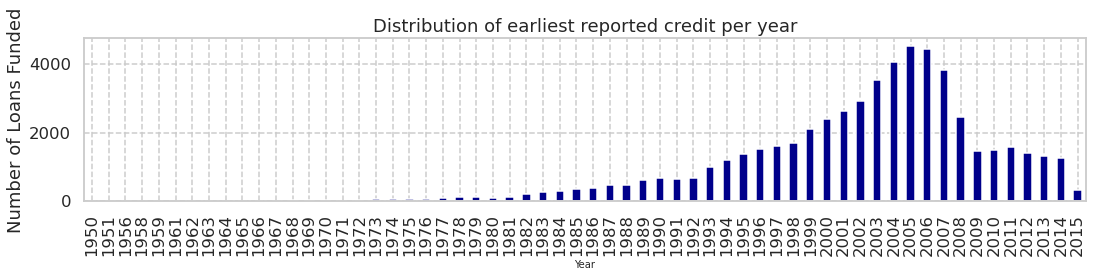

In [18]:
# check number of loans by time
f,ax=plt.subplots(figsize=(16,3))

df['earliest_cr_line'].dt.year.value_counts().sort_index().plot.bar(color='darkblue', ax=ax)
ax.set_title('Distribution of earliest reported credit per year')
ax.set_ylabel('Number of Loans Funded')
ax.set_xlabel('Year', fontsize=10)

plt.show()

In [19]:
loans=df.copy()

In [20]:
loans['loan_status'].value_counts(dropna=False)

0    47444
1     8867
Name: loan_status, dtype: int64

**Feature Engineering**: generate the length between earliest reported credit and issue_d 

#### 3. Categorical fields
made up of character strings or being presented as factors 
- Location fields
   - addr_state: try binning and one-hot encoding
   - zip code: no processing here
- emp_title: The job title supplied by the Borrower when applying for the loan 
   - nunique: 64020, There are too many different job titles for this feature to be useful, so we drop it.
   - or binning it to different industry based on the meaning?  
- purpose: Loan purpose provided by the borrower.
   - nunique: 13, binning and one-hot encoding 
- title: The loan title provided by the borrower
   - nunique: 12, binning and one-hot encoding  
- home_ownership
- disbursement_method
- emp_length
- application_type

In [21]:
text_field = list(data_dic[data_dic.type == 'string'].Column_Name)
text_field = [col_name for col_name in loans.columns if col_name in text_field]
text_field

['term',
 'emp_title',
 'emp_length',
 'home_ownership',
 'loan_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'application_type',
 'disbursement_method']

In [22]:
pd.crosstab(loans.purpose,loans.title)

title,business,car financing,credit card refinancing,debt consolidation,green loan,home buying,home improvement,major purchase,medical expenses,moving and relocation,other,vacation
purpose,,,,,,,,,,,,
car,0,776,0,0,0,0,0,0,0,0,0,0
credit_card,0,0,11396,0,0,0,0,0,0,0,0,0
debt_consolidation,0,0,0,28731,0,0,0,0,0,0,0,0
home_improvement,0,0,0,0,0,0,4521,0,0,0,0,0
house,0,0,0,0,0,997,0,0,0,0,0,0
major_purchase,0,0,0,0,0,0,0,1806,0,0,0,0
medical,0,0,0,0,0,0,0,0,1031,0,0,0
moving,0,0,0,0,0,0,0,0,0,507,0,0
other,0,0,0,0,0,0,0,0,0,0,5403,0


<p>
<span style="color:blue">
> title and purpose provide same info
</span>
</p>

#### Distribution plot for all categorical variables

**All distribution plots are saved at `plots/categorical`**

**Findings**
- application who rent flat/house have highest risk while own a mortage have lowest risk
- emp lenghth > 10 years, risk is lower
- purpose/title: car financing have lowest risk
- application type: joint application have higher risk
- disbursement_method: received by cash have higher risk

**Feature Engineering**: binning/one-hot encoding/label encoding

#### 4. Distribution plot for all Numerical variables

In [34]:
def plot_num(i, col_name, full_name, label, df, path):
    
    df = df[[col_name, label]].sort_values(col_name)
    tmp = df.dropna(axis=0)
    
    fig = plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(2, 2)
    fig.subplots_adjust(top=0.3)

    # 1) Histogram Plot
    ax = fig.add_subplot(gs[0, :1])
    ax = sns.distplot(tmp[col_name], kde=False)
    ax.set(title='Histogram')
    
    # 2) ROC Plot
    ax = fig.add_subplot(gs[0, 1:])
    clf = LogisticRegression()
    X = tmp[col_name].values.reshape(-1,1)
    y = tmp[label].values
    clf.fit(X, y)
    y_pred = clf.predict_proba(X)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
    auc = metrics.roc_auc_score(y, y_pred)
    plt.plot(fpr,tpr,label=  full_name + '(AUC = %0.2f)' %auc)
    plt.legend(loc=4)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC curve')
    
    
    # 3) Default rate by quantile
    if tmp[col_name].nunique() > 30:
        # continuous numeric
        df['group'] = pd.qcut(df[col_name], 10, duplicates='drop')
        df['group'] = np.where(df.group.isna(), 'missing', df.group).astype(str)
        df_plot = df.groupby('group').agg({col_name: min,label: np.mean}).reset_index().rename(columns={'loan_status':'default_rate'}).sort_values(col_name).reset_index(drop = True)
        df_plot['x'] = df_plot.index
        ax = fig.add_subplot(gs[1, :])
        sns.lineplot(data=df_plot, x="x", y='default_rate')
        plt.xticks(df_plot.x, df_plot.group, rotation=60)
        plt.yticks([])
        ax.set(xlabel=col_name, ylabel = 'Rate', title='Rate by Quantile')
    else:
        # discrete numeric
        df_plot = df.groupby(col_name)[label].mean().reset_index().rename(columns={'loan_status':'default_rate'})
        ax = fig.add_subplot(gs[1, :])
        sns.lineplot(data=df_plot, x=col_name, y='default_rate')
        ax.set(xlabel=col_name, ylabel = 'Default Rate', title='Bad Rate by Group')
    
    
    plt.tight_layout()
    fig.suptitle('Feature: {}, N: {}, Min: {}, Max: {}, NAs: {:.0%}'.format(col_name, df.shape[0], df[col_name].min(), df[col_name].max(), df[col_name].isna().mean()  ), y =0.98)
    fig.savefig("plots/{}/{}-{}.png".format(path,i,full_name))
    plt.close()
    # plt.show()

In [35]:
plot_num(0, 'bc_open_to_buy', 'feature', 'loan_status', loans, 'numeric')

**All distribution plots are saved at `plots/numeric`**

**Findings**


#### 5. Correlatiion

- Correlation is a measure of the linear relationship of 2 or more variables. Through correlation, we can predict one variable from the other.
- The logic behind using correlation for feature selection is that the good variables are highly correlated with the target.
- A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables.


#### 6. Multicollinearity Analysis
Multicollinearity refers to a situation in which more than two explanatory variables in a multiple regression model are highly linearly related. Below are few of the multicollinear features based on correlation matrix.


Note: Correlation is only an indication of presence of multicollinearity, removing features only on the basis of the correlation can lead to a loosing valuable information.
The best way to identify the multicollinearity is to calculate the Variance Inflation Factor (VIF) for every feature in the Dataset.
Other way is to use regression techniques like Ridge or Lasso, in these models we use extra lambda value which penalizes some of the coefficients for particular columns which in turn reduces the effect of multicollinearity.
or use tree based methods, decision trees are by nature immune to multi-collinearity

In [23]:
# correlaion for numerical features
def get_redundant_pairs(df):
    '''
    Get diagonal and lower triangular pairs of correlation matrix
    '''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


In [24]:
num_df = loans.select_dtypes('number')
high_corr = get_top_abs_correlations(num_df, n=20)

In [25]:
loans = loans.drop(np.unique(pd.DataFrame(high_corr).index.get_level_values(1)), axis=1, errors='ignore')

In [26]:
loans = loans.drop(['id'], axis=1, errors='ignore')

In [27]:
# correlatiion for categorical features
cat_feat = loans.select_dtypes('object').columns.values
comb_cat_feat = np.array(list(combinations(cat_feat, 2)))
corr_cat_feat = np.array([])
for comb in comb_cat_feat:
    table = pd.pivot_table(loans, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
    corr_cat_feat = np.append(corr_cat_feat, corr)

In [28]:
high_corr_cat = comb_cat_feat[corr_cat_feat >= 0.8]
high_corr_cat

array([['purpose', 'title'],
       ['zip_code', 'addr_state']], dtype='<U19')

In [29]:
loans = loans.drop(np.unique(high_corr_cat[:, 0]), axis=1, errors='ignore')

#### 7. Missing value

- missing value processing 
  - logistical regression is sensitive to missing value
  - igonore records with missing or imputated by mean, median or by value decided by the proportion of y
  - generate missing indicators before missing value processing 
  

In [30]:
loans.isnull().mean().sort_values(ascending=False)[:20]

dti_joint                      0.874163
revol_bal_joint                0.874163
annual_inc_joint               0.874163
mths_since_last_record         0.852178
mths_since_recent_bc_dlq       0.793912
mths_since_last_major_derog    0.758022
mths_since_last_delinq         0.552485
il_util                        0.166309
emp_title                      0.095665
emp_length                     0.087621
mths_since_recent_inq          0.083483
mths_since_rcnt_il             0.033173
mo_sin_old_il_acct             0.033173
bc_open_to_buy                 0.016977
mths_since_recent_bc           0.015734
dti                            0.002682
revol_util                     0.001314
all_util                       0.000266
avg_cur_bal                    0.000089
pct_tl_nvr_dlq                 0.000018
dtype: float64

#### 8. outlier
- logistical regression is sensitive to outliers


## Step 3 Data Transformation

- Feature Engineering
- Correct format
- Data encoding: label encoding or one-hot encoding
- Missing value indicator
- Feature scaling (Optional)


### 3.1 Format correcting

In [31]:
def formatting(data, str_replace, col):
    data[col] = data[col].replace(str_replace, regex = True)
    data[col] = data[col].apply(pd.to_numeric, errors='coerce', axis=1)
    
    return data


In [32]:
col = ['emp_length', 'term']
str_replace = {'years':'',
               'year':'',
               ' ':'',
               '<':'',
               '\+':'',
               'n/a':'0',
               'months':''}

data_clean = formatting(loans, str_replace, col)

In [33]:
data_clean['loan_status'].value_counts(dropna=False)

0    47444
1     8867
Name: loan_status, dtype: int64

### 3.2 Treatment on date columns
- calculated the difference between dates and issue_date

In [34]:
def data_cal(data, issue_date):
    
    date_field = data.select_dtypes(include=np.datetime64).columns.drop(labels=issue_date)
    for var in date_field:
        new_col = '_'.join((var,'length'))
        data[new_col] = (data[issue_date] - data[var]).dt.days
    
    return data

In [35]:
data_clean = data_cal(data_clean, issue_date = 'issue_d')

### 3.3 Treatment on Joint application
- replace value of specific columns if it is a joint application

In [36]:
def replace_joint(data):
    joint_cols = [col for col in data.columns if 'joint' in col]
    for col in joint_cols:
        raw_col = col.replace('_joint', '')
        data[raw_col] = np.where(data["application_type"] == 'individual', data[raw_col], data[col])
    
    display(data.shape)
    data.drop(joint_cols, axis=1, inplace = True)
    display(data.shape)
    
    return data

data_clean = replace_joint(data_clean)

(56311, 66)

(56311, 63)

### 3.4 Treatement on text field (emp_title) 

In [37]:
def text_extraction(data, col, field):
    for var in field:
        new_col = '_'.join(('is', var))
        data[new_col] = data[col].str.contains(var)
        data[new_col] = (data[new_col] == True).astype(int)
    
    display(data.shape)
    data.drop(col, axis=1, inplace = True)
    display(data.shape)
    
    return data

data_clean = text_extraction(data_clean, col = 'emp_title', field = ['manager', 'teacher'])

(56311, 65)

(56311, 64)

### 3.5 Drop columns 
- date or text columns with unique value greater than 50 or column we want to move 

In [38]:
def drop_col(data, col):
    date_field = data.select_dtypes(include=np.datetime64).columns
    text_field = data[data.select_dtypes(include=object).columns]
    text_field = text_field.loc[:, (text_field.nunique() >= 50) | (text_field.nunique() == 0)].columns
    dop_col = list(date_field) + list(text_field) + list(col)
    
    display(data.shape)
    data.drop(dop_col, axis=1, inplace = True, errors = 'ignore')
    display(data.shape)
    
    return data

data_clean = drop_col(data_clean, ['purpose'])

(56311, 64)

(56311, 61)

### 3.6 Label encoding

In [39]:
def label_encoding(data, lookup, col):
    data[col] = data[col].map(lookup)
    return data

lookup = {"mortgage":6, "rent":5, "own":4, "other":3, "none":2, "any":1}
data_clean = label_encoding(data_clean, lookup, 'home_ownership')

### 3.7 One hot encoding

In [40]:
def one_hot_encoding(data):
    text_field = loans.select_dtypes(include=object).columns
    
    display(data.shape)
    data = pd.get_dummies(data, columns=text_field, drop_first=True)
    display(data.shape)
    
    return data

data_clean = one_hot_encoding(data_clean)

(56311, 61)

(56311, 71)

### 3.8 Missing Indicator

In [41]:
def missing_flag(data):
    print(data.shape)
    final = pd.concat([data, data.notnull().astype(int).add_suffix('_present')], axis=1)
    identical_fractions = final.apply(pd.Series.nunique)
    drop_iden = sorted(list(identical_fractions[identical_fractions == 1].index))
    final = final.drop(labels=drop_iden, axis=1)
    print(final.shape)
    
    return final

In [42]:
data_clean = missing_flag(data_clean)

(56311, 71)
(56311, 86)


In [43]:
data_clean.to_json('input/CleanedData.json', orient='table')

### 3.9 Feature scaling (optional)
- Gradient Descent Based Algorithms: speed the optimisation process
- Distance based algorithm, KNN, K-MEANS, SVM: necessary 
- Tree-Based Algorithms: Not necessary 
- min-max normalization, mean normalization, Standardization  ...